### Import & configure required packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

def format_float(x):
    return '{:.2f}'.format(x)

pd.option_context('mode.use_inf_as_na', True)
pd.set_option('display.float_format', format_float)
pd.set_option('display.max_rows', None)

### Load the 2022 US Survey of Consumer Finances STATA data

In [2]:
# Lood the data into a dataframe
df = pd.read_stata("../data/scf2022_extract.dta")

# Check that the data has been loaded correctly
expected_shape = (22975, 357)
assert df.shape == expected_shape, f"Expected shape {expected_shape}, but got {df.shape} - data not loaded correctly"

print("Dataframe loaded correctly")

# Capitalise all column names
df.columns = df.columns.str.upper()

# Add weights WGT0 column, 5 times the WGT column
df["WGT0"] = df["WGT"] * 5

Dataframe loaded correctly


### Target variable
Target variable is risk tolerance - a proxy variable derived from ratio of higher risk to lower risk investment total holdings

Proxy variables - higher risk investment total holdings:
* Stocks (STOCKS)
* Bonds (BOND)
* Non money market funds (NMMF)

Proxy variables - lower risk investment total holdings:
* Savings account (SAVING)
* Money market deposit account (MMDA)
* Money market funds (MMMF)
* Savings bonds (SAVBND)
* Certificate of deposit (CDS)


In [3]:
# Define the category of the proxy variables
higher_risk_columns = df[["STOCKS", "BOND", "NMMF"]]
lower_risk_columns= df[["SAVING", "MMDA", "MMMF", "SAVBND", "CDS"]]

# Calculate the sums of the proxy variables in each category
higher_risk_total_holdings = higher_risk_columns.sum(axis=1)
lower_risk_total_holdings = lower_risk_columns.sum(axis=1)

# Calculate total holdings - used for pre-processing and risk tolerance calculaiton
total_holdings = higher_risk_total_holdings + lower_risk_total_holdings

# Calculate risk tolerance
risk_tolerance = higher_risk_total_holdings / total_holdings

# Add new columns to dataframe
df = pd.concat([df, higher_risk_total_holdings.rename("HRTOTALHOLDINGS"), lower_risk_total_holdings.rename("LRTOTALHOLDINGS"), total_holdings.rename("TOTALHOLDINGS"), risk_tolerance.rename("RISKTOLERANCE")], axis=1)

### Preparing the target variable (2) - preprocessing/filtering

Remove rows with total holdings < 10000 
* Removes NaN due to division by 0
* Risk tolerance also not useful if small amounts invested - e.g. 90usd in stocks and 10usd in savings would give 0.9 risk tolerance, not very useful

In [4]:
df = df[df["TOTALHOLDINGS"] >= 10000]

### Weighted sampling - to ensure the data is representative of the population
Adv:
Dont have to worry about the weights when training the model
Nearly identical result to using the weighted dataset

Disadvantages:
Slower than using the weighted dataset
The results are probablistic.

In [5]:
# mean risk tolerance before accounting for weights
print(df["RISKTOLERANCE"].mean())

# Drop the implicates, keeping only every 1st of 5 rows
df = df.drop_duplicates(subset="YY1", keep='first')

# The weights make the regression metrics innacurate so random sampling w/ weights is used to get a representative sample
df = df.sample(n=10000, replace=True, weights=df["WGT0"], random_state=15)

# Mean risk tolerance (after sampling to account for weights)
print(df["RISKTOLERANCE"].mean())

0.5054575650601605
0.3469399788092077


### Compute the most correlated variables with the risk tolerance variable

In [6]:
# Compute the most correlated variables with the risk tolerance variable
correlation = df.corr()["RISKTOLERANCE"].sort_values(ascending=False)
print(correlation)

RISKTOLERANCE      1.00
HNMMF              0.59
HSTOCKS            0.55
HBROK              0.50
HTRAD              0.44
ASSETCAT           0.39
NWCAT              0.39
NWPCTLECAT         0.39
HEQUITY            0.37
NSTOCKS            0.33
EQUITINC           0.30
EQUITY             0.30
DEQ                0.30
HRTOTALHOLDINGS    0.29
FIN                0.28
TOTALHOLDINGS      0.26
HOMEEQ             0.26
HOUSES             0.26
NINCCAT            0.25
INCPCTLECAT        0.25
INCCAT             0.24
EDUC               0.24
HCALL              0.24
NINCPCTLECAT       0.24
NINC2CAT           0.24
NMMF               0.23
STMUTF             0.23
STOCKS             0.22
EDCL               0.21
NORMINC            0.20
RETQLIQ            0.20
INCQRTCAT          0.20
INTDIVINC          0.20
FINLIT             0.19
NINCQRTCAT         0.19
ASSET              0.18
KGHOUSE            0.18
RETEQ              0.18
NETWORTH           0.17
KGSTMF             0.17
HBOND              0.17
HRETQLIQ        

### Distribution of the risk tolerance variable

<Axes: xlabel='RISKTOLERANCE', ylabel='Count'>

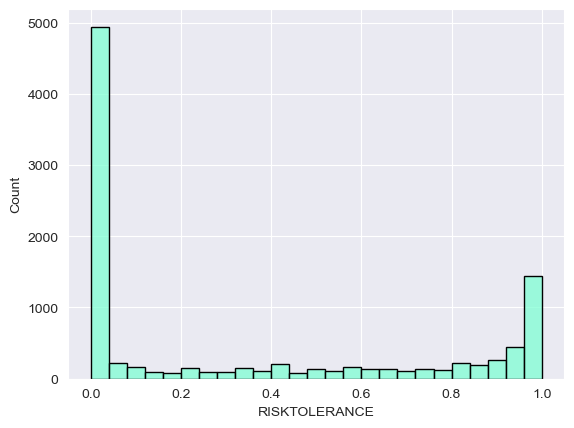

In [7]:
sns.histplot(df['RISKTOLERANCE'], kde=False, bins=25, color='aquamarine', edgecolor='black')

### Feature Selection
* Married? (MARRIED) - 1=Married/living with partner, 2= not,
* No. of children (KIDS)
* Occupation category 2 (OCCAT2) - occupation classification for reference person:
    1=managerial/professional 2=technical/sales/services,
    3=other (incl. production/craft/repair workers, operators,
    laborers, farmers, foresters, fishers) 4=not working;
* Income (INCOME):
* Net worth (NETWORTH):
* Value of primary residence (HOUSES):
* Education (EDUC): 1=no high school diploma/GED, 2=high school diploma or GED,
    3=some college or Assoc. degree, 4=Bachelors degree or higher;
* Financial literacy (FINLIT) - number of correct answers to 3 financial literacy questions


In [8]:
# Select the features for the model
feature_columns = ["MARRIED", "KIDS", "OCCAT2", "INCOME", "NETWORTH", "HOUSES", "EDUC", "FINLIT"]

# Add the target variable to the list of columns
all_columns = feature_columns + ["RISKTOLERANCE"]

# Drop the other columns from the dataset
df = df.drop(df.columns.difference(all_columns), axis=1)

# Reorder the columns to match the order of the all_columns list
df = df[all_columns]

### Correlation of the selected features

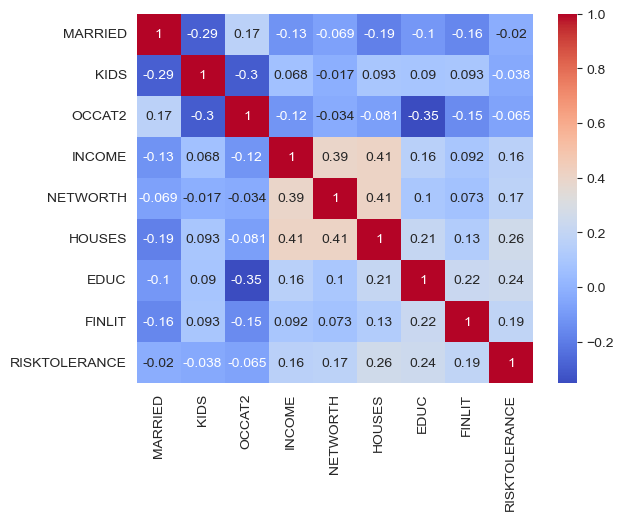

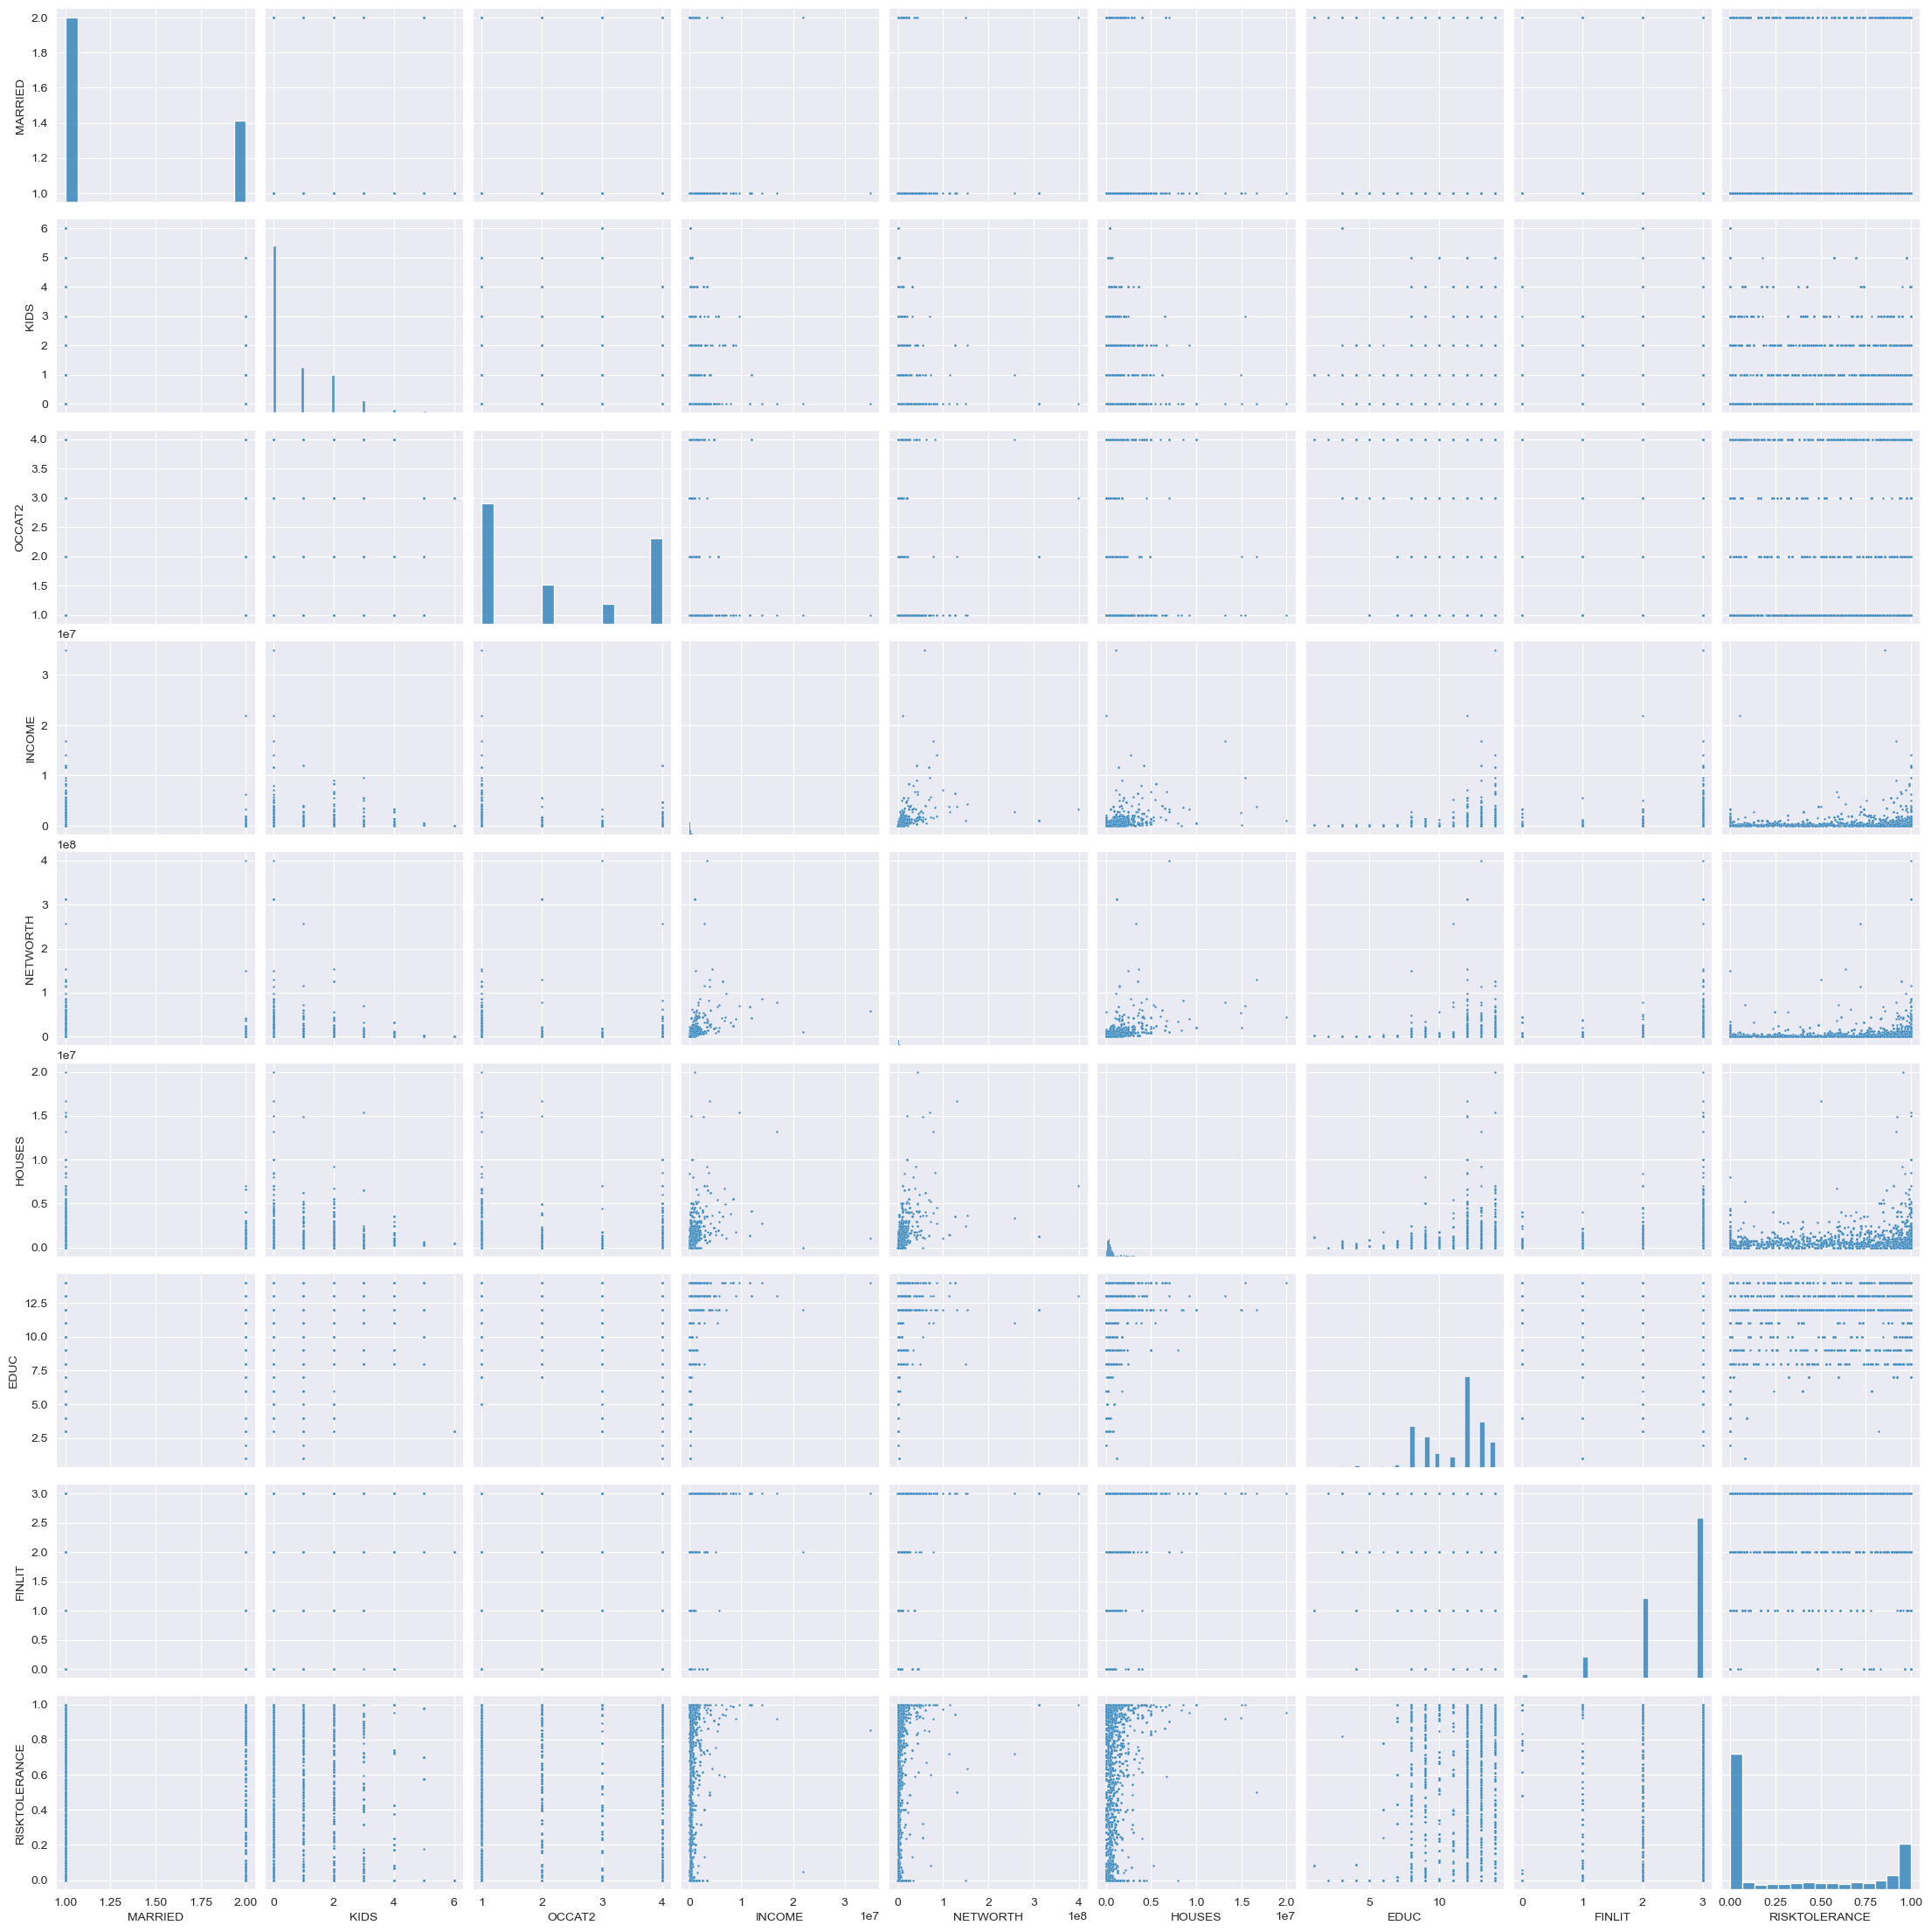

In [9]:
# Correlation matrix
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

# Scatterplot matrix
sns.pairplot(df, plot_kws={'s': 3})

### Training options

In [10]:
fixed_seed = 15
num_folds = 5

### Splitting data into training and testing sets
Training set: 70%
Validation set: 15%
Testing set: 15%

In [11]:
x = df.drop("RISKTOLERANCE", axis=1)
y = df["RISKTOLERANCE"]

# Standardisation
scaler = StandardScaler().fit(x)
x = scaler.transform(x)

x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.3, random_state=fixed_seed)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=fixed_seed)

### Defining sklearn models for model determination

In [12]:
models = []

# Linear models
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('RIDGE', Ridge()))
models.append(('EN', ElasticNet())) # Combines Lasso and Ridge
# Ensemble models - boosting
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Ensemble models - bagging
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))
# Other models
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor())) # Classification and Regression Trees
models.append(('SVR', SVR())) # Support Vector Machine (SVM)

### Evaluate models

In [13]:
# Evaluate each model w/ k-fold cross validation (set to 5) using neg RMSE, neg MSE, neg MAE and r2 as metrics
evaluation_metrics = ['neg_root_mean_squared_error', 'neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=fixed_seed)

# Evaluate each model
results = []
for model_name, model in models:
    # Add the metrics dictionary to the results for this model
    results.append({'model_name': model_name, 'metrics': {metric: [] for metric in evaluation_metrics}})
    # Evaluate the model using each metric
    for metric in evaluation_metrics:
        cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=metric)
        results[-1]['metrics'][metric].append(cv_results)
        print(f"Model: {model_name}, Metric: {metric}, Mean: {cv_results.mean():.4f}, Std: {cv_results.std():.4f}")
    print("\n")
    
    

Model: LR, Metric: neg_root_mean_squared_error, Mean: -0.3839, Std: 0.0051
Model: LR, Metric: neg_mean_squared_error, Mean: -0.1474, Std: 0.0039
Model: LR, Metric: neg_mean_absolute_error, Mean: -0.3394, Std: 0.0043
Model: LR, Metric: r2, Mean: 0.1226, Std: 0.0190


Model: LASSO, Metric: neg_root_mean_squared_error, Mean: -0.4100, Std: 0.0025
Model: LASSO, Metric: neg_mean_squared_error, Mean: -0.1681, Std: 0.0021
Model: LASSO, Metric: neg_mean_absolute_error, Mean: -0.3778, Std: 0.0025
Model: LASSO, Metric: r2, Mean: -0.0009, Std: 0.0013


Model: RIDGE, Metric: neg_root_mean_squared_error, Mean: -0.3839, Std: 0.0051
Model: RIDGE, Metric: neg_mean_squared_error, Mean: -0.1474, Std: 0.0039
Model: RIDGE, Metric: neg_mean_absolute_error, Mean: -0.3394, Std: 0.0043
Model: RIDGE, Metric: r2, Mean: 0.1226, Std: 0.0190

Model: EN, Metric: neg_root_mean_squared_error, Mean: -0.4100, Std: 0.0025
Model: EN, Metric: neg_mean_squared_error, Mean: -0.1681, Std: 0.0021
Model: EN, Metric: neg_mean_ab

Results: Extra Trees Regressor (ETR) has the best performance based on the evaluation metrics

Model: ETR, Metric: neg_root_mean_squared_error, Mean: -0.1103, Std: 0.0099
Model: ETR, Metric: neg_mean_squared_error, Mean: -0.0122, Std: 0.0025
Model: ETR, Metric: neg_mean_absolute_error, Mean: -0.0245, Std: 0.0051
Model: ETR, Metric: r2, Mean: 0.9273, Std: 0.0139

### Compare models w/ boxplot for each metric

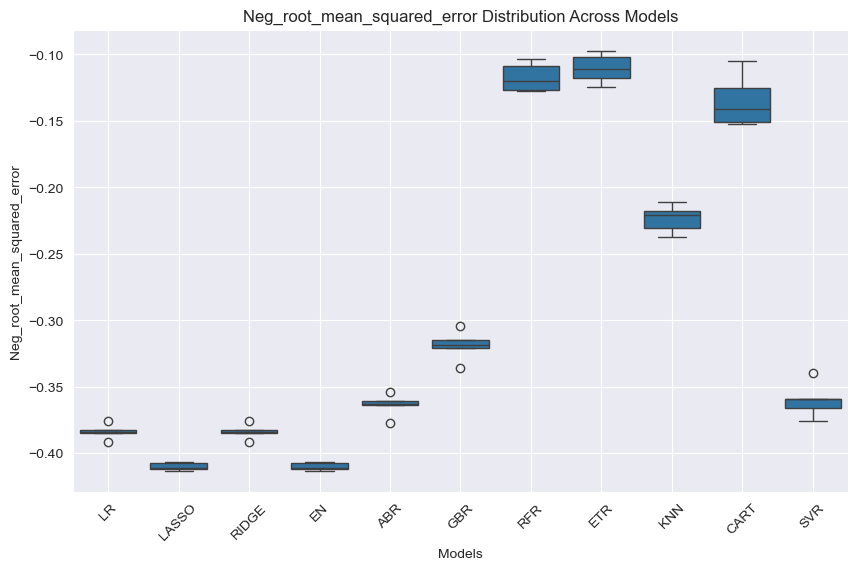

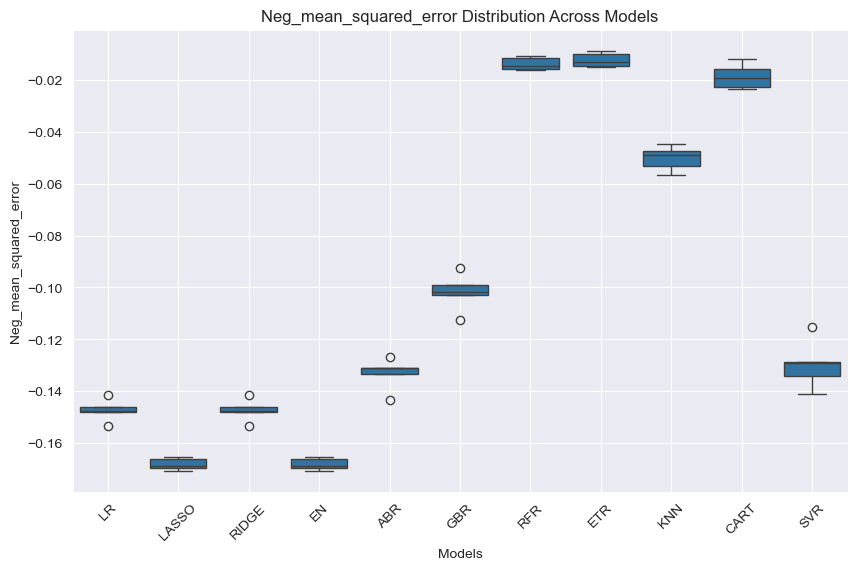

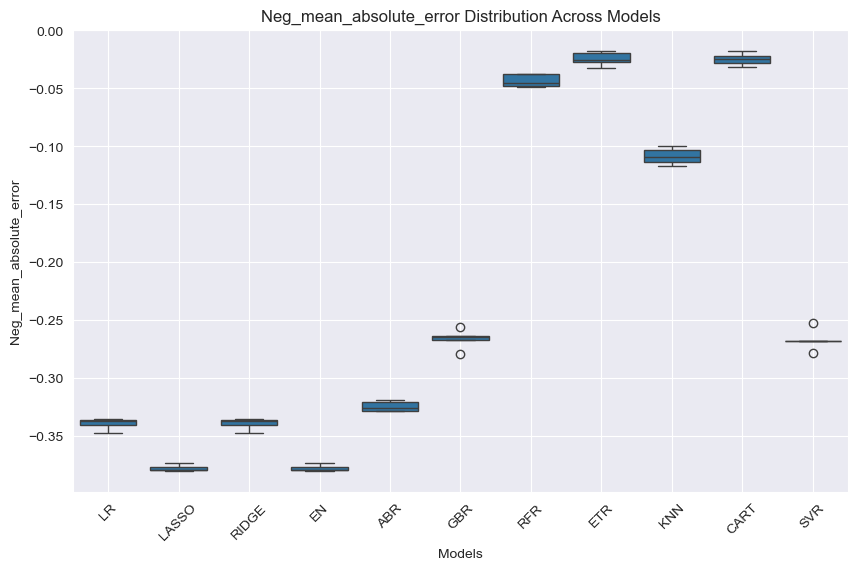

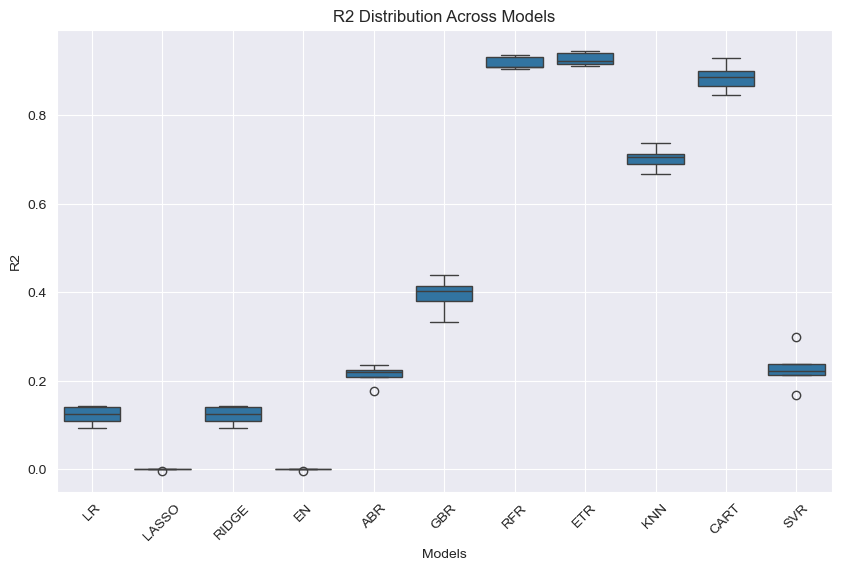

In [14]:
for metric in evaluation_metrics:
    metric_data = []
    model_names = []
    for model in results:
        metric_data.extend(model['metrics'][metric][0])
        model_names.extend([model['model_name']] * len(model['metrics'][metric][0]))
 
    df = pd.DataFrame({'Model': model_names, metric.capitalize(): metric_data})
    
    # Plot boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Model', y=metric.capitalize(), data=df)
    plt.title(f'{metric.capitalize()} Distribution Across Models')
    plt.ylabel(f'{metric.capitalize()}')
    plt.xlabel('Models')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

### Hyperparameter tuning
Extra trees regression model (ETR) has the best performance based on the evaluation metrics so will continue with it, attempting to improve it further with hyperparameter tuning. 

Grid search was prohibitively slow, so will use random search instead. Strategy- course search first for speed then fine search to ensure best hyperparameters are found.

In [15]:
model = ExtraTreesRegressor()

param_grid = {
    'n_estimators': [300, 350, 400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [30, 40, 50],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 4],
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, scoring='r2', cv=kfold, n_jobs=4)
random_result = random_search.fit(x_train, y_train)

print(f"Best: {random_result.best_score_} using {random_result.best_params_}")

Best: 0.9292620075845706 using {'n_estimators': 350, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}


### Hyperparameter tuning results
Best: 0.9292620075845706 using {'n_estimators': 350, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}

### Model evaluation on validation set, test how well the model generalises to unseen data

In [16]:
# Train the model with best hyperparameters on the training set
etr = ExtraTreesRegressor(n_estimators=350, min_samples_split=3, min_samples_leaf=1, max_features='sqrt', max_depth=40)
etr.fit(x_train, y_train)

# Evaluate the model on the validation set
y_val_pred = etr.predict(x_val)

# Metrics on validation set
r2_val = r2_score(y_val, y_val_pred)
mse_val = sum((y_val - y_val_pred) ** 2) / len(y_val)
rmse_val = mse_val ** 0.5
mae_val = sum(abs(y_val - y_val_pred)) / len(y_val)

# Print the metrics
print(f"Validation set metrics:")
print(f"R2: {r2_val:.4f}")
print(f"MSE: {mse_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")
print(f"MAE: {mae_val:.4f}")

Validation set metrics:
R2: 0.9664
MSE: 0.0054
RMSE: 0.0738
MAE: 0.0151


### Final validation set results - happy with the performance
R2: 0.9664
MSE: 0.0054
RMSE: 0.0738
MAE: 0.0151

Text(0.5, 0, 'Feature')

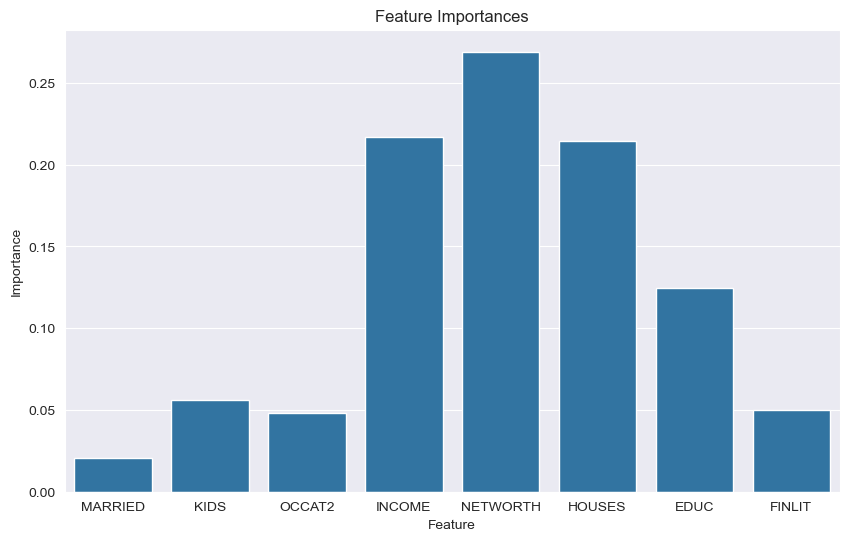

In [17]:
# Show chart of feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_columns, y=etr.feature_importances_)
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')

### Model now finalised, use test metrics on the test set

In [18]:
y_test_pred = etr.predict(x_test)

# Metrics on test set
r2_test = r2_score(y_test, y_test_pred)
mse_test = sum((y_test - y_test_pred) ** 2) / len(y_test)
rmse_test = mse_test ** 0.5
mae_test = sum(abs(y_test - y_test_pred)) / len(y_test)

# Print the metrics
print(f"test set metrics:")
print(f"R2: {r2_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE: {mae_test:.4f}")

test set metrics:
R2: 0.9616
MSE: 0.0064
RMSE: 0.0802
MAE: 0.0166


Results -  model generalises well to unseen data
R2: 0.9616
MSE: 0.0064
RMSE: 0.0802
MAE: 0.0166

### Dump the model for use by the ML API

In [19]:
from joblib import dump
dump(etr, '../models/final_model.joblib')

['../models/final_model.joblib']

### Dump the scaler for use by the ML API

In [20]:
dump(scaler, '../models/scaler.joblib')

['../models/scaler.joblib']